In [1]:
from skimage import io, color, exposure, transform
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

Using TensorFlow backend.


In [2]:
# Some constants

batch_size = 128
epochs = 10

In [3]:
# %load preprocess_images.py

# Pre-process the images and add the labels for them
IMG_SIZE = 32
NUM_CLASSES=62
ROOT_PATH = 'C:/Users/cristian.schuszter/Desktop'

root_training_dir = ROOT_PATH + '/Traffic sign recognition dataset/Training'
root_testing_dir = ROOT_PATH + '/Traffic sign recognition dataset/Testing'

def preprocess_image(img):
    """
    Take an image from the initial ppm dataset and then preprocess it so that it looks good.
    Then, resize to some standard shape provided above
    """
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)
    
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2 : centre[0] + min_side // 2,
             centre[1] - min_side // 2 : centre[1] + min_side // 2]
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE), mode = 'reflect')
    #img = np.rollaxis(img, -1)
    return img


def get_class(path):
    cls = int(path.split('\\')[-2])
    return cls

def get_tsr_train_data():
    all_image_paths = glob.glob(os.path.join(root_training_dir, '*/*.ppm'))
    imgs = []
    labels = []
    count = 0
    np.random.shuffle(all_image_paths)
    for img_path in all_image_paths:
        img = preprocess_image(io.imread(img_path))
        label = get_class(img_path)
        labels.append(label)
        if count % 20 == 0:
            print('{:.2f}% of all training images processed'.format((count / len(all_image_paths) * 100)))
        count+=1
        imgs.append(img)
    print ('Done processing training images!')
    return imgs, labels
    

def get_tsr_test_data():
    all_image_paths = glob.glob(os.path.join(root_testing_dir, '*/*.ppm'))
    imgs = []
    labels = []
    count = 0
    np.random.shuffle(all_image_paths)
    for img_path in all_image_paths:
        img = preprocess_image(io.imread(img_path))
        label = get_class(img_path)
        labels.append(label)
        if count % 20 == 0:
            print('{:.2f}% of all testing images processed'.format((count / len(all_image_paths) * 100)))
        count+=1
        imgs.append(img)
    print ('Done processing test images!')
    return imgs, labels

### Step 1: Extract and train the data

In [4]:
imgs, labels = get_tsr_train_data()

0.00% of all training images processed
0.44% of all training images processed
0.87% of all training images processed
1.31% of all training images processed
1.75% of all training images processed
2.19% of all training images processed
2.62% of all training images processed
3.06% of all training images processed
3.50% of all training images processed
3.93% of all training images processed
4.37% of all training images processed
4.81% of all training images processed
5.25% of all training images processed
5.68% of all training images processed
6.12% of all training images processed
6.56% of all training images processed
6.99% of all training images processed
7.43% of all training images processed
7.87% of all training images processed
8.31% of all training images processed
8.74% of all training images processed
9.18% of all training images processed
9.62% of all training images processed
10.05% of all training images processed
10.49% of all training images processed
10.93% of all training 

90.49% of all training images processed
90.93% of all training images processed
91.37% of all training images processed
91.80% of all training images processed
92.24% of all training images processed
92.68% of all training images processed
93.11% of all training images processed
93.55% of all training images processed
93.99% of all training images processed
94.43% of all training images processed
94.86% of all training images processed
95.30% of all training images processed
95.74% of all training images processed
96.17% of all training images processed
96.61% of all training images processed
97.05% of all training images processed
97.49% of all training images processed
97.92% of all training images processed
98.36% of all training images processed
98.80% of all training images processed
99.23% of all training images processed
99.67% of all training images processed
Done processing training images!


In [5]:
test_x, labels_y = get_tsr_test_data()

0.00% of all testing images processed
0.79% of all testing images processed
1.59% of all testing images processed
2.38% of all testing images processed
3.17% of all testing images processed
3.97% of all testing images processed
4.76% of all testing images processed
5.56% of all testing images processed
6.35% of all testing images processed
7.14% of all testing images processed
7.94% of all testing images processed
8.73% of all testing images processed
9.52% of all testing images processed
10.32% of all testing images processed
11.11% of all testing images processed
11.90% of all testing images processed
12.70% of all testing images processed
13.49% of all testing images processed
14.29% of all testing images processed
15.08% of all testing images processed
15.87% of all testing images processed
16.67% of all testing images processed
17.46% of all testing images processed
18.25% of all testing images processed
19.05% of all testing images processed
19.84% of all testing images processed

In [6]:
print(K.image_data_format())

channels_last


In [7]:
def get_input_shape():
    if K.image_data_format() == 'channels_first':
        return (3, IMG_SIZE, IMG_SIZE)
    else:
        return (IMG_SIZE, IMG_SIZE, 3)

In [8]:
def reformat_entries_to_model_shape(x_train, x_test):
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[2], IMG_SIZE, IMG_SIZE)
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[2], IMG_SIZE, IMG_SIZE)
        input_shape = (1, IMG_SIZE, IMG_SIZE)
    else:
        x_train = x_train.reshape(x_train.shape[0], IMG_SIZE, IMG_SIZE, 1)
        input_shape = (IMG_SIZE, IMG_SIZE, 1)
    return x_train, x_test

In [9]:
# Turn the labels into rows of matrices with 1 on the corresponding class and 0 on the rest

test_y = keras.utils.to_categorical(labels_y)
train_y = keras.utils.to_categorical(labels)

In [10]:
np.rollaxis(np.array(test_x), -1).shape

(3, 2520, 32, 32)

In [11]:
np.array(test_x).shape

(2520, 32, 32, 3)

### Step 2: Build and train the network

In [12]:
# Build a convolutional network similar to the MNIST case
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu', 
                 input_shape=get_input_shape()))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


In [13]:
get_input_shape()

(32, 32, 3)

In [14]:
train_output = model.fit(np.array(imgs), train_y,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(np.array(test_x), test_y))

Train on 4575 samples, validate on 2520 samples
Epoch 1/10
4575/4575 [==============================] - 17s - loss: 3.0212 - acc: 0.2999 - val_loss: 1.7612 - val_acc: 0.5579
Epoch 2/10
4575/4575 [==============================] - 17s - loss: 1.6195 - acc: 0.6140 - val_loss: 0.9652 - val_acc: 0.7913
Epoch 3/10
4575/4575 [==============================] - 17s - loss: 0.9900 - acc: 0.7541 - val_loss: 0.5433 - val_acc: 0.8774
Epoch 4/10
4575/4575 [==============================] - 16s - loss: 0.6693 - acc: 0.8192 - val_loss: 0.4226 - val_acc: 0.8944
Epoch 5/10
4575/4575 [==============================] - 17s - loss: 0.5170 - acc: 0.8544 - val_loss: 0.3136 - val_acc: 0.9206
Epoch 6/10
4575/4575 [==============================] - 17s - loss: 0.3937 - acc: 0.8833 - val_loss: 0.3199 - val_acc: 0.9194
Epoch 7/10
4575/4575 [==============================] - 16s - loss: 0.3280 - acc: 0.9038 - val_loss: 0.2521 - val_acc: 0.9325
Epoch 8/10
4575/4575 [==============================] - 17s - loss: 0.

In [15]:
score = model.evaluate(np.array(test_x), test_y, verbose=0)
print('Test loss:', score[0])
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Test loss: 0.227549628015

acc: 94.40%


### Step 3: Metrics and graphs

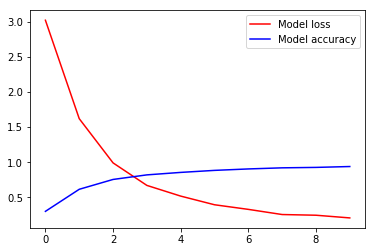

In [16]:
loss = plt.plot(train_output.epoch, train_output.history['loss'], color='r', label='Loss')
acc = plt.plot(train_output.epoch, train_output.history['acc'], color='b', label='Accuracy')
plt.legend(['Model loss', 'Model accuracy'])
plt.savefig(ROOT_PATH + '/cnn-model-loss.png')
plt.show()

Train acc: 0.9954098360655738
Test acc: 0.9440476188583979


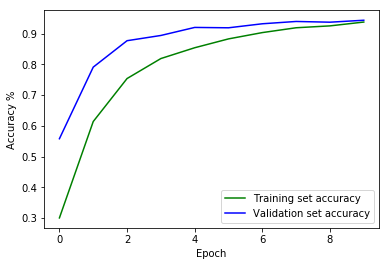

In [17]:
scores_train =  model.evaluate(np.array(imgs), train_y, verbose=0)
scores_validation =  model.evaluate(np.array(test_x), test_y, verbose=0)

print('Train acc: {}'.format( scores_train[1]))
print('Test acc: {}'.format(scores_validation[1]))

acc_trn = plt.plot(train_output.epoch, train_output.history['acc'], color='g', label='Train acc')
acc_val = plt.plot(train_output.epoch, train_output.history['val_acc'], color='b', label='Validation acc')
plt.title = 'Training / validation set accuracies per epoch'
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')

plt.legend(['Training set accuracy', 'Validation set accuracy'])
plt.savefig(ROOT_PATH + '/cnn-accuracies.png')

plt.show()

### Step 4: Visualize the built network

In [18]:
# plot it in the console

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file=ROOT_PATH + '/cnn_arch.png')